## Getting Started

Need `plotly` version to be 4.6.0 in order for the code to work, try to restart kernel or reset runtime if any error occurs

In [23]:
'''
try:
    import plotly
    if plotly.__version__ == '4.6.0':
        print('Success')
    else:
        print('Upgrading...')
        !pip install plotly --upgrade
except ImportError:
    print('No available module')
    print('Installing...')
    !pip install plotly==4.6.0
    print('Success')
    
!pip install geopandas
!pip install country_converter
'''

"\ntry:\n    import plotly\n    if plotly.__version__ == '4.6.0':\n        print('Success')\n    else:\n        print('Upgrading...')\n        !pip install plotly --upgrade\nexcept ImportError:\n    print('No available module')\n    print('Installing...')\n    !pip install plotly==4.6.0\n    print('Success')\n    \n!pip install geopandas\n!pip install country_converter\n"

In [24]:
import os
import sys
import re

import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import folium

import descartes
import country_converter as coco

sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

---
## Load Data

In [25]:
# read happiness data into a list of dataframe
base_url = 'https://raw.githubusercontent.com/Benjaminnnnnn/CSE-163-FINAL-PROJECT/master/data'
files = [base_url + '/' + str(i) + '.csv' for i in range(2015, 2020)]

dataframes = [pd.read_csv(file) for file in files]

Let's see if each year's happiness data has the same dataformat (Unfortunately they don't neccesarily have the same column length nor column names) 

In [26]:
print('Length of Each Year\'s Happiness Data')
print([len(df.columns) for df in dataframes])
print()

print('Column Names for Each Year\'s Happiness Data')
print()
for df in dataframes:
    # A peek of the column differences
    print(df.columns.values[0:5])
    print()

Length of Each Year's Happiness Data
[12, 13, 12, 9, 9]

Column Names for Each Year's Happiness Data

['Country' 'Region' 'Happiness Rank' 'Happiness Score' 'Standard Error']

['Country' 'Region' 'Happiness Rank' 'Happiness Score'
 'Lower Confidence Interval']

['Country' 'Happiness.Rank' 'Happiness.Score' 'Whisker.high' 'Whisker.low']

['Overall rank' 'Country or region' 'Score' 'GDP per capita'
 'Social support']

['Overall rank' 'Country or region' 'Score' 'GDP per capita'
 'Social support']



Because they use slightly different column names to record the happiness data, we need to do similar name matching. Besides, there is no `Year` column in any of the dataset. So we want to add a `Year` column for computing the trend of happiness over year.

---
## Data Processing

In [27]:
# add an year column to each year's happiness data
year = 2015
for df in dataframes:
    df['Year'] = year
    year+=1

Compare the data format (column names) between `2015` and `2017`

In [28]:
dataframes[0].head(2)

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Year
0,Switzerland,Western Europe,1,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738,2015
1,Iceland,Western Europe,2,7.561,0.04884,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201,2015


In [29]:
dataframes[2].head(2)

,Country,Happiness.Rank,Happiness.Score,Whisker.high,Whisker.low,Economy..GDP.per.Capita.,Family,Health..Life.Expectancy.,Freedom,Generosity,Trust..Government.Corruption.,Dystopia.Residual,Year
0,Norway,1,7.537,7.594445,7.479556,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027,2017
1,Denmark,2,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707,2017


In [30]:
print('Column numbers for each dataset')
print([len(df.columns) for df in dataframes])

Column numbers for each dataset
[13, 14, 13, 10, 10]


Since each year has slightly different style of documenting the happiness scores (i.e. they have different number of columns and column names), we need to make some data transformation that filter out all the columns that we need, and standardize their names by using `re`.

In [31]:
# create the columns to be extracted
# store the regex pattern of column and its full name in
# a pair of tuple, [0] for pattern, [1] for full name

columns = list(map(lambda x: ('(?i).*' + x[0] + '(?i).*', x[1]),
                       [('rank', 'happiness rank'),
                        ('country', 'country'),
                        ('score', 'happiness score'),
                        ('GDP', 'GDP per capita'),
                        ('family', 'family'),
                        ('social', 'family'), # same as "family" but some year use "social support" as the column name
                        ('freedom', 'freedom'),
                        ('health', 'life expectancy'),
                        ('corruption', 'government corruption'), 
                        ('trust', 'government corruption'), # same as "corruption"
                        ('generosity', 'generosity'),
                        ('year', 'year')
                        ])
              )


# using regex to match similar column names
# case-insensitive
column_filter = re.compile('|'.join([col_name[0] for col_name in columns]))

In [32]:
# filtering out all the matching columns
for i, df in enumerate(dataframes):
    all_matches = list(filter(column_filter.match, df.columns))
    dataframes[i] = df[all_matches]

Rename all the extracted columns for each dataset and make them consistent

In [33]:
def rename_cols(dataframes, sub_patterns):
    '''
    Rename the columns of the given dataframes to
    the sub_pattern defined.
    
    Parameters:
        - dataframes        - a list of dataframes to be renamed
        - sub_patterns      - a list of tuples consists matching patterns
                              on the first entry, and the replacements on
                              the second entry
        
    Returns:
        - renamed_dfs       - renamed dataframes
    '''
    # col  - column
    # pat  - pattern
    # repl - replacement
    for i, df in enumerate(dataframes):
        new_cols = {}
        for col in df.columns:
            for pat, repl in columns:
                if re.match(pat, col):
                    new_cols[col] = re.sub(pat, repl, col)
        dataframes[i] = df.rename(columns=new_cols)
    return dataframes

In [34]:
dataframes = rename_cols(dataframes, columns)
# check if the rename is correct by peeking one dataframe
dataframes[2].head(1)

,country,happiness rank,happiness score,GDP per capita,family,life expectancy,freedom,generosity,government corruption,year
0,Norway,1,7.537,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2017


Since all the column names are consistent now, let's concatnate the data for each year into one dataframe

In [35]:
happiness_data = pd.concat(dataframes, ignore_index=True)

In [36]:
happiness_data.shape

(782, 10)

In [37]:
print('Null Value in the Dataset')
print(happiness_data.isnull().sum())

Null Value in the Dataset
GDP per capita           0
country                  0
family                   0
freedom                  0
generosity               0
government corruption    1
happiness rank           0
happiness score          0
life expectancy          0
year                     0
dtype: int64


In [38]:
happiness_data.describe()

,GDP per capita,family,freedom,generosity,government corruption,happiness rank,happiness score,life expectancy,year
count,782.000000,782.000000,782.000000,782.000000,781.000000,782.000000,782.000000,782.000000,782.000000
mean,0.916047,1.078392,0.411091,0.218576,0.125436,78.698210,5.379018,0.612416,2016.993606
std,0.407340,0.329548,0.152880,0.122321,0.105816,45.182384,1.127456,0.248309,1.417364
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.693000,0.000000,2015.000000
25%,0.606500,0.869363,0.309768,0.130000,0.054000,40.000000,4.509750,0.440183,2016.000000
50%,0.982205,1.124735,0.431000,0.201982,0.091000,79.000000,5.322000,0.647310,2017.000000
75%,1.236187,1.327250,0.531000,0.278832,0.156030,118.000000,6.189500,0.808000,2018.000000
max,2.096000,1.644000,0.724000,0.838075,0.551910,158.000000,7.769000,1.141000,2019.000000


## Research Questions
---

### Question 1
What is the distribution of the happiness scores? (I'm just plotting some graphs, and I will choose whichever that is more informative later)

Let's see the distribution of happiness score each year

In [39]:
# make subplots for each year's distribution
fig = make_subplots(rows=1, cols=5, shared_yaxes=True, vertical_spacing=0.04)
# similar to ax in matplotlib
traces = []
# getting colors for plotting
color_discrete_sequence = px.colors.qualitative.D3

for i, color in list(zip(range(2015, 2020), color_discrete_sequence)):
    data = happiness_data[happiness_data['year']==i]['happiness score']
    mean_score = data.mean()
    
    # add a histogram to the figure
    fig.add_trace(go.Histogram(x=data, 
                               name=i, 
                               hovertemplate='Count %{y}', 
                               text='%{y}', 
                               nbinsx=10), 
                  row=1, col=i-2014)
    # update fig x range
    fig.update_xaxes(nticks=10)
    
    # add a vertical line (mean happiness score) to the figure
    fig.add_trace(go.Scatter(x=[round(mean_score, 2)] * 50, y=np.arange(-1, 40), 
                             line=dict(
                                 color=color_discrete_sequence[i-2019]
                             ), 
                             name=str(i)+' Mean', 
                             showlegend=False, 
                             mode='lines',
                             hovertemplate=round(mean_score, 2)),
                  row=1, col=i-2014)

# update the entire subplots layout
fig.update_layout(height=430, title='Happiness Score Yearly Distribution', 
                  legend_title_text='Year', yaxis=dict(range=[0, 30]),
                  hovermode='x unified')
fig.show()

And let's see some correlation between happiness data

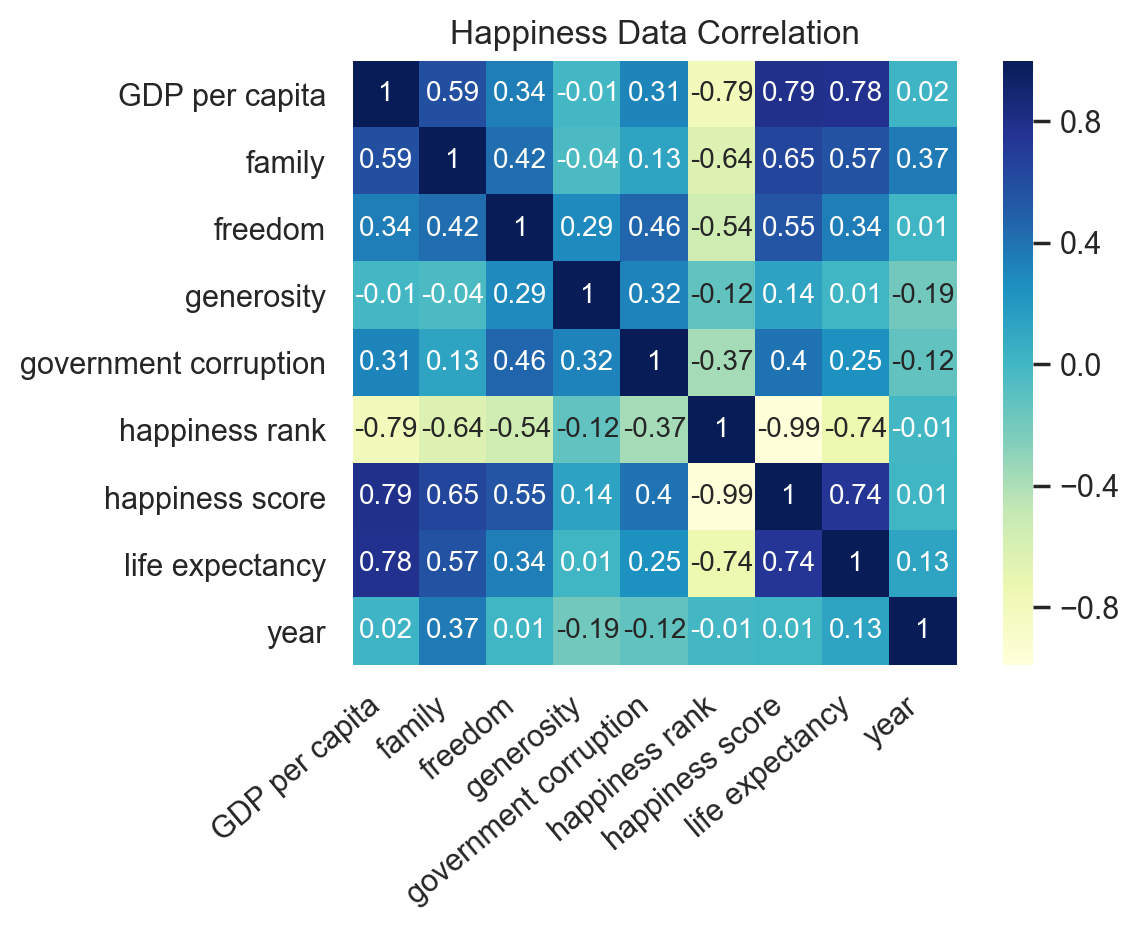

In [40]:
# correlation of each columns with respect another column in the happiness data
corr = happiness_data.corr().apply(lambda x: round(x, 2))

# create high resolution figure
fig, ax = plt.subplots(1, 1, dpi=200)
ax = sns.heatmap(corr, square=True, annot=True, cmap='YlGnBu')

# set the orientation of the x labels
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=40,
    horizontalalignment='right'
)
ax.set_title('Happiness Data Correlation', fontsize=12)
fig.show()

Now let's project our happiness score to a globe

In [49]:
# create choropleth map data
# locations by country
data = go.Choropleth(locations=happiness_data['country'],
                     locationmode='country names',
                     z=happiness_data['happiness score'],
                     text=happiness_data['country'],
                     colorbar={'title':'Happiness Score'},
                     colorscale=px.colors.sequential.Pinkyl)

# display ocean on the map
# projection is orthographic
# show grid for both lon and lat
layout = go.Layout(title='Happiness Score Distribution',
                   geo=dict(showframe=False,
                            showocean=True,
                            projection={'type':'orthographic'},
                            oceancolor='rgb(0,119,190)',
                            lonaxis=dict(showgrid=True,
                                         gridcolor='rgb(102,102,102)'),
                            lataxis=dict(showgrid=True,
                                         gridcolor='rgb(102,102,102)')))
# plotting
fig = go.Figure(data=data,
                layout=layout)
fig.show()